In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
from importlib import reload

import sys
sys.path.append("../../include")
import hhtools
import hhsignal

In [259]:
# Load data
def load(fname):
    import pickle as pkl
    with open(fname, "rb") as fp:
        return pkl.load(fp)

summary_obj = load("../../three_pop_mpi/simulation_data/orders.pkl")["obj"]
summary_obj.fdir = "../../three_pop_mpi/simulation_data/data"
repr_points = load("../../three_pop_mpi/clustering/data/cluster_repr_points_rank3.pkl")

# Set explanable frequency threshold

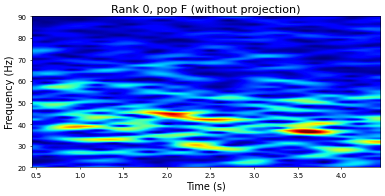

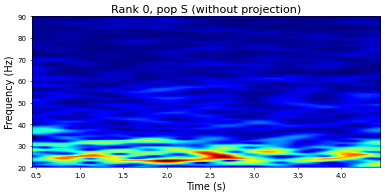

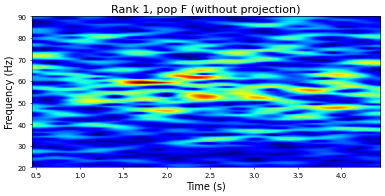

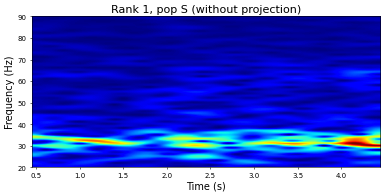

In [8]:
# show independent
pop_type = ["", "F", "S"]
for nrank in range(2):
    # Show data
    detail_data = summary_obj.load_detail(*[0,0,nrank,0,0])

    # get spectrogram
    for tp in range(1, 3):
        psd, fpsd, tpsd = hhsignal.get_stfft(detail_data["vlfp"][tp], detail_data["ts"], 2000, mbin_t=0.1, wbin_t=1, frange=(3, 150))

        plt.figure(figsize=(9, 4), dpi=50)
        hhtools.imshow_xy(psd, x=tpsd, y=fpsd, cmap="jet", interpolation="spline16")
        plt.ylim([20, 90])
        plt.xlabel("Time (s)", fontsize=14)
        plt.ylabel("Frequency (Hz)", fontsize=14)
        plt.title("Rank %d, pop %s (without projection)"%(nrank, pop_type[tp]), fontsize=16)
        
        plt.savefig("./figs/no_proj_spectrogram_rank%d_pop%s"%(nrank, pop_type[tp]), dpi=150)
        
        plt.show()

In [193]:
# we can define no-mans area : rank0: 27-32 (give the same area for slow and fast frequency oscillation)

In [232]:
reload(bt)

<module 'burst_tools' from '/home/jungyoung/Project/hh_neuralnet/gen_three_pop_samples/multifreq_burst/burst_tools.py'>

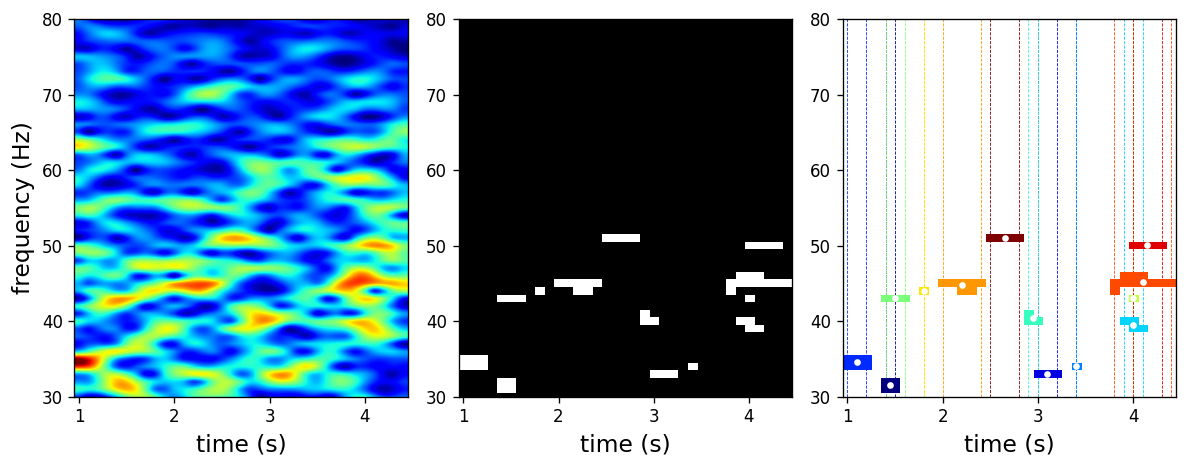

In [256]:
detail_data = summary_obj.load_detail(*[5,10,1,0,0])
flim = (30, 80)

vlfp, t = cut_start(detail_data["vlfp"][1], detail_data["ts"])
psd, fpsd, tpsd = hhsignal.get_stfft(vlfp, t, 2000, mbin_t=0.1, wbin_t=1, frange=(3, 150))
# pth = bt.get_pth_percentile(psd.flatten(), 99.5)
# pth = np.average(psd) + 3.5*np.std(psd)
pth = bt.get_pth_percentile(psd.flatten(), 99)
im_bin = psd >= pth
im_class = bt.find_blob(im_bin)
burst_f, burst_range = bt.extract_burst_attrib(psd, fpsd, im_class)

fig, axs = plt.subplots(1, 3, figsize=(10, 4), dpi=120)
bt.draw_binarize_psd(psd, pth, x=tpsd, y=fpsd, flim=flim, ylabel="frequency (Hz)", xlabel="time (s)", axs=axs[:2])

plt.axes(axs[2])
bt.draw_burst_attrib(im_class, burst_f, burst_range, tpsd=tpsd, fpsd=fpsd, flim=flim)
plt.xlabel("time (s)", fontsize=14)

plt.ylim(flim)
plt.tight_layout()

plt.savefig("./figs/burst_sample.png", dpi=150)
plt.show()

## Set threshold (test)

In [306]:
# Sample with 1st cluster
cid_set, cid_order = [], []
with open("../data/picked_cluster.txt", "r") as fp:
    line = fp.readline() # description line
    line = fp.readline()
    while line:
        buf = line.split(",")
        cid_set.append(int(buf[0]))
        cid_order.append(int(buf[1]))
        line = fp.readline()

with open("../../three_pop_mpi/clustering/data/cluster_repr_points_rank3.pkl", "rb") as fp:
    cluster_info = pkl.load(fp)

loc_pick_points = []
for cid, co in zip(cid_set, cid_order):
    loc = cluster_info["loc_points"][cid-1][co]
    loc_pick_points.append(loc)

# nalpha, nbeta, nrank, nw
loc_pick_points = np.array(loc_pick_points, dtype=int)

In [370]:
from tqdm.notebook import tqdm

psd_m1 = np.zeros([3, 2])
psd_m2 = np.zeros([3, 2])
psd_std = np.zeros([3, 2])

for nrank in range(3):
    nid = np.where(loc_pick_points[:,2] == nrank)[0]
    for n in tqdm(nid):
        itr = np.random.choice(9)
        detail_data = summary_obj.load_detail(*loc_pick_points[n], itr) # consider iteration
        for i in range(2):
            vlfp, t = cut_start(detail_data["vlfp"][i+1], detail_data["ts"])
            psd, fpsd, tpsd = hhsignal.get_stfft(vlfp, t, 2000, mbin_t=0.1, wbin_t=1, frange=(10, 100))
            
            psd_m1[nrank, i] += np.average(psd)
            psd_m2[nrank, i] += np.average(psd**2)
    
    psd_m1[nrank, :] /= len(nid)
    psd_m2[nrank, :] /= len(nid)
    
    psd_std[nrank, :] = np.sqrt(psd_m2[nrank, :] - psd_m1[nrank, :]**2)
    

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/384 [00:00<?, ?it/s]

  0%|          | 0/716 [00:00<?, ?it/s]

In [404]:
summary_obj.num_total

42525

In [410]:
summary_obj.num_controls

[15, 15, 3, 7, 9]

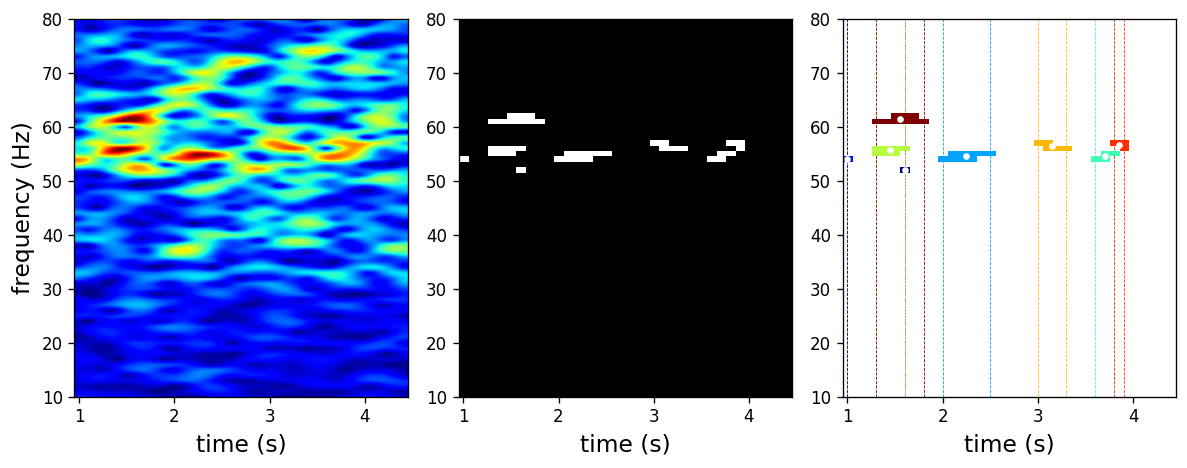

In [409]:
pth = psd_m1 + 3*psd_std

nid = 500
nc = 0 # 0: F, 1: S
std_ratio = 3.29
flim = (10, 80)

detail_data = summary_obj.load_detail(*loc_pick_points[nid], 0)
vlfp, t = cut_start(detail_data["vlfp"][nc+1], detail_data["ts"])
psd, fpsd, tpsd = hhsignal.get_stfft(vlfp, t, 2000, mbin_t=0.1, wbin_t=1, frange=(10, 100))
nrank = loc_pick_points[nid, 2]

# pth = psd_m1[nrank, nc] + std_ratio * psd_std[nrank, nc]
pth = th["th_psd"][nid, nc]

im_bin = psd >= pth
im_class = bt.find_blob(im_bin)
burst_f, burst_range = bt.extract_burst_attrib(psd, fpsd, im_class)

fig, axs = plt.subplots(1, 3, figsize=(10, 4), dpi=120)
bt.draw_binarize_psd(psd, pth, x=tpsd, y=fpsd, flim=flim, ylabel="frequency (Hz)", xlabel="time (s)", axs=axs[:2])

plt.axes(axs[2])
bt.draw_burst_attrib(im_class, burst_f, burst_range, tpsd=tpsd, fpsd=fpsd, flim=flim)
plt.xlabel("time (s)", fontsize=14)

plt.ylim(flim)
plt.tight_layout()

In [407]:
with open("./th_tmp.pkl", "rb") as fp:
    th = pkl.load(fp)

In [406]:
data

{'th_psd': array([[0.18717672, 0.18717672],
        [0.18717672, 0.18717672],
        [0.18717672, 0.18717672],
        ...,
        [0.5845972 , 0.5845972 ],
        [0.5845972 , 0.5845972 ],
        [0.5845972 , 0.5845972 ]]),
 'th_m': array([[0.04673047, 0.04673047],
        [0.04673047, 0.04673047],
        [0.04673047, 0.04673047],
        ...,
        [0.12411298, 0.12411298],
        [0.12411298, 0.12411298],
        [0.12411298, 0.12411298]]),
 'th_s': array([[0.04268883, 0.04268883],
        [0.04268883, 0.04268883],
        [0.04268883, 0.04268883],
        ...,
        [0.13996481, 0.13996481],
        [0.13996481, 0.13996481],
        [0.13996481, 0.13996481]]),
 'std_ratio': 3.29,
 'method': 'absolute',
 'fdir_data': '../data_tmp',
 'updated': '2023-6-30'}